# Analyze ladder pilot counts in DESeq2

In [1]:
library("data.table")
library("dplyr")
library("DESeq2")
# for parallelization
library("BiocParallel")
register(MulticoreParam(8))

setwd("/home/users/rang/crispey3/ladder_pilot_feb2021/")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, 

## Setup path to files

In [2]:
# samples info file
samples_info_file = "./ladder_pilot_samples.txt"
# counts file
counts_file = "./counts/pbc_counts.txt"

# output directory
dir.create("./deseq/")
# deseq results file
deseq_output_file= "./deseq/ladder_pilot_deseq_results.txt"

print("Input files:")
print(samples_info_file)
print(counts_file)
print("Output files:")
print(deseq_output_file)


Warning message in dir.create("./deseq/"):
“'./deseq' already exists”


[1] "Input files:"
[1] "./ladder_pilot_samples.txt"
[1] "./counts/pbc_counts.txt"
[1] "Output files:"
[1] "./deseq/ladder_pilot_deseq_results.txt"


## Load samples info, barcode counts

In [3]:
# loading samples
samples <- read.table(file = samples_info_file, header = TRUE, sep = '\t', row.names = 1)
samples$rep = factor(samples$rep)

# loading counts
counts <- fread(counts_file, header=TRUE, sep = '\t', na.strings="", data.table=TRUE)
colnames(counts) <- c('barcode', rownames(samples))

# store in DESeqDataSet
dds <- DESeqDataSetFromMatrix(countData = as.matrix(counts, rownames = 1),
                              colData = samples,
                              design= ~gen+rep)

# DDS overview
dds

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.



class: DESeqDataSet 
dim: 42 42 
metadata(1): version
assays(1): counts
rownames(42): AAGAACAAATGC ACGACTAAGTTG ... TTGCCATTGTCC TTTGCGGTGCCT
rowData names(0):
colnames(42): t0-1 t0-2 ... t6-5 t6-6
colData names(2): gen rep

## Filter by total read count

In [4]:
# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 1000

keep <- rowSums(counts(dds)) >= total_reads_cutoff
dds <- dds[keep,]


## run DESeq in default settings, compare to limma results

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 42 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 19, 45%
LFC < 0 (down)     : 20, 48%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



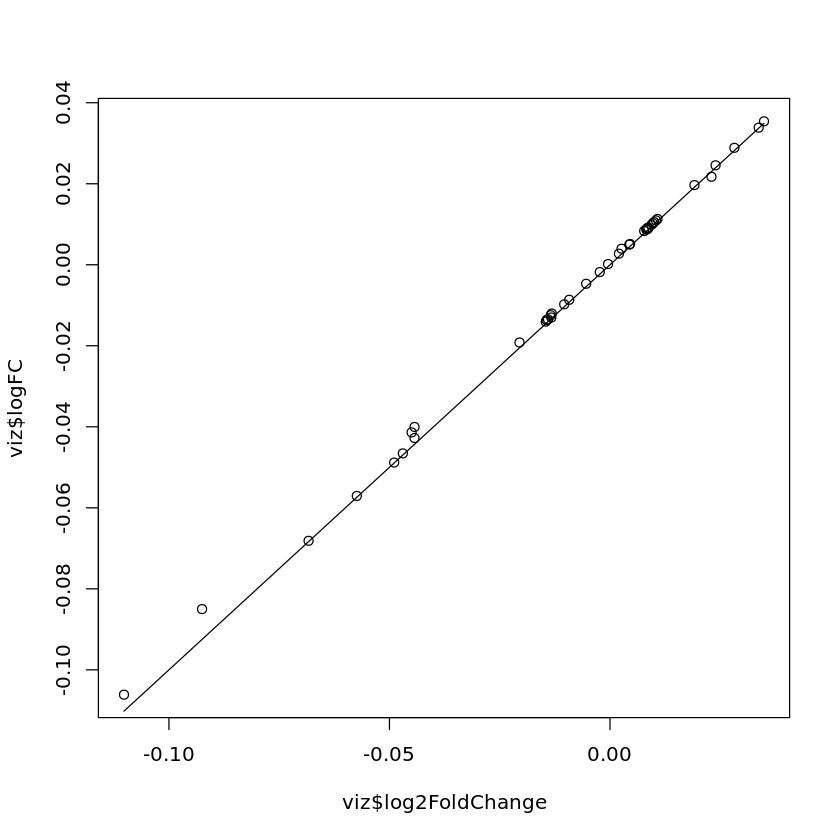

In [5]:
dds <- DESeq(dds)
res <- results(dds, name='gen')
summary(res)

# compare with limma
limma_results_file = './limma/ladder_pilot_limma_results.txt'
limma_results = read.table(file = limma_results_file, header = TRUE, sep = '\t', row.names = 1)

# log2FoldChange vs logFC
viz <- cbind(res, limma_results[rownames(res),])
plot(viz$log2FoldChange,viz$logFC)
lines(viz$log2FoldChange, viz$log2FoldChange, type = "l")

## Break down DESeq function steps to select specific control genes

In [6]:
ladder_oligos_annotation_file <- 'ladder_oligos_annotated.txt'
ladder_oligos_annotation <- fread(file = ladder_oligos_annotation_file, header = TRUE, sep = '\t', data.table=FALSE)

# get neutral PBCs
neutral_pbc = as.vector(ladder_oligos_annotation[ladder_oligos_annotation$breslow_growth_rate==1,'PBC'])
neutral_pbc

[1] "ACTAATGCCCGC" "CTAACAAGGCAC"

In [7]:
# re-run DESeq
dds <- DESeqDataSetFromMatrix(countData = as.matrix(counts, rownames = 1),
                              colData = samples,
                              design= ~gen+rep)

# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 1000

keep <- rowSums(counts(dds)) >= total_reads_cutoff
dds <- dds[keep,]

# estimate size factors, specifying neutral oligos as control genes
dds <- estimateSizeFactors(dds, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds)))
# estimate dispersion
dds <- estimateDispersions(dds)
# calculate logFC
dds <- nbinomWaldTest(dds)


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



## Compare DESeq log2FoldChange to limma logFC_adj (adjusted by mean logFC of neutral PBCs)


out of 42 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6, 14%
LFC < 0 (down)     : 27, 64%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



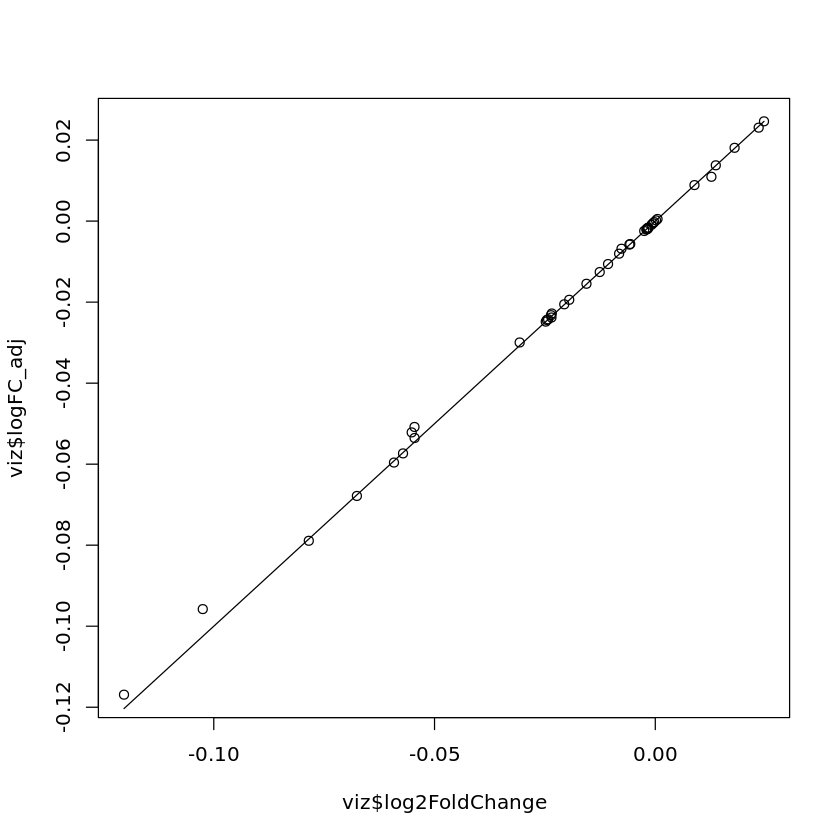

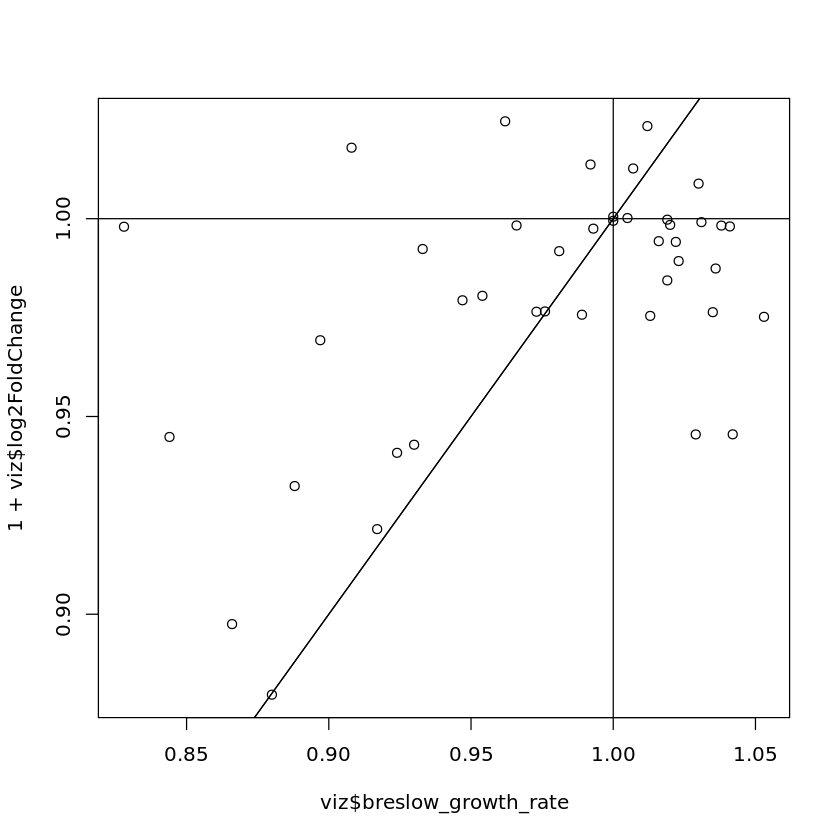

In [8]:
res <- results(dds, name='gen', alpha=0.05)
summary(res)

# compare with limma (annotated)
limma_results_annotated_file <- 'ladder_pilot_limma_results_annotated.txt'
limma_results_annotated <- read.table(file = limma_results_annotated_file, header = TRUE, sep = '\t', row.names = 1)
rownames(limma_results_annotated) = limma_results_annotated$PBC

# log2FoldChange vs logFC_adj
viz <- cbind(res, limma_results_annotated[rownames(res),])
plot(viz$log2FoldChange,viz$logFC_adj)
lines(viz$log2FoldChange, viz$log2FoldChange, type = "l")

# breslow_growth_rate vs log2FoldChange->fitness (1+lfc)
plot(viz$breslow_growth_rate, 1+viz$log2FoldChange)
abline(h=1)
abline(v=1)
lines(viz$breslow_growth_rate, viz$breslow_growth_rate, type = "l")

# # log2FoldChange->fitness vs crispey_fitness
# plot(2**viz$log2FoldChange,viz$crispey_fitness)
# lines(2**viz$log2FoldChange, 2**viz$log2FoldChange, type = "l")

# # breslow_growth_rate vs crispey_fitness
# plot(viz$breslow_growth_rate, viz$crispey_fitness)
# abline(h=1)
# abline(v=1)

In [9]:
# view table of results sorted by pvalue
resOrdered <- res[order(res$pvalue),]
resOrdered

# export results to file
write.csv(as.data.frame(resOrdered), file=deseq_output_file)

log2 fold change (MLE): gen 
Wald test p-value: gen 
DataFrame with 42 rows and 6 columns
                     baseMean        log2FoldChange                lfcSE
                    <numeric>             <numeric>            <numeric>
ACGACTAAGTTG 539.968068467321   -0.0784772369752048  0.00139785218575982
AGTCGCATTGAG 108.515841207367    -0.120334202498369  0.00317586117979901
TTGATCATTCCG  1090.0114004851   -0.0675860490070871  0.00120126593502445
GTGAACGTAGGT 287.103753739882   -0.0545140914995989  0.00162417818467037
ACTTGCGTAACG 1411.71024344234   -0.0571381308187614  0.00178308682928824
...                       ...                   ...                  ...
CAACCGTGGGCT 1247.34305657988 -0.000862772874532913 0.000914732777283884
ACTAATGCCCGC 2563.27700844269 -0.000524256952131522 0.000563237610086975
CTAACAAGGCAC 2252.87063621369  0.000508828238459423 0.000590810115556007
CGCAGTCGTCAA 756.260013512404 -0.000238096306581364  0.00103510981364633
GAGCAACCAGTA 2415.37495924278   0.

### We can prototype a GxG/GxE analysis workflow in DESeq2 by modifying the sample info table to create two pseudo conditions between rep123 and rep456 (called "cond"), and fitting a new design with gen*cond and rep*cond interaction terms...

In [10]:
samples_pseudocond_file <- "./ladder_pilot_samples_pseudoConditions.txt"
# loading samples
samples_pseudocond <- read.table(file = samples_pseudocond_file, header = TRUE, sep = '\t', row.names = 1)
samples_pseudocond$rep = factor(samples_pseudocond$rep)

In [11]:
# re-run DESeq
dds2 <- DESeqDataSetFromMatrix(countData = as.matrix(counts, rownames = 1),
                                         colData = samples_pseudocond,
                                         design= ~gen+rep+cond+gen:cond+rep:cond)

# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 1000

keep <- rowSums(counts(dds2)) >= total_reads_cutoff
dds2 <- dds2[keep,]

# estimate size factors, specifying neutral oligos as control genes
dds2 <- estimateSizeFactors(dds2, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds2)))
# estimate dispersion
dds2 <- estimateDispersions(dds2)
# calculate logFC
dds2 <- nbinomWaldTest(dds2)


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [12]:
resultsNames(dds2)

[1] "Intercept"   "gen"         "rep_2_vs_1"  "rep_3_vs_1"  "cond_B_vs_A"
[6] "gen.condB"   "rep2.condB"  "rep3.condB"

In [13]:
# fitness in cond A (rep123)
res2 <- results(dds2, name='gen')
summary(res2)

# fitness in cond B (rep456)
res3 <- results(dds2, contrast=list( c("gen","gen.condB") ))
summary(res3)

# identify significant changes in fitness between conditions
res4 <- results(dds2, name='gen.condB')
summary(res4)

# when comparing across multiple conds (e.g. GxG comparing between non-reference strains), use list to compare interaction terms directly
# e.g. results(dds2, contrast=list("gen.condC", "gen.condB")) 


out of 42 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5, 12%
LFC < 0 (down)     : 28, 67%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 42 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6, 14%
LFC < 0 (down)     : 26, 62%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 42 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



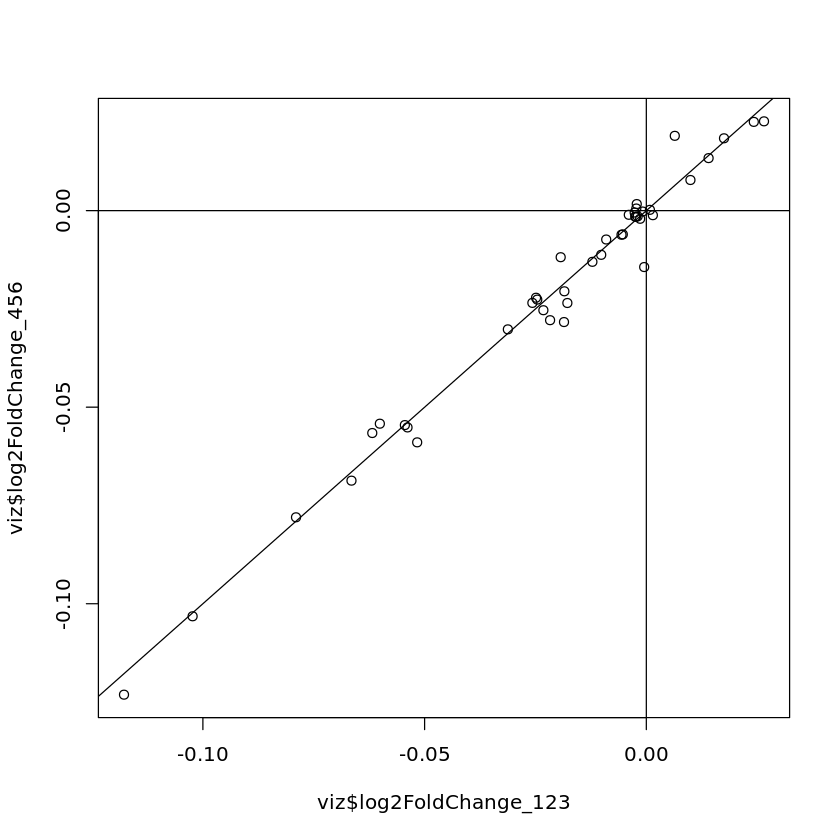

In [14]:
# log2FoldChange rep123 vs rep456

viz <- cbind(res2, res3[rownames(res2),])
colnames(viz) <- c(paste0(colnames(res2), "_123"), paste0(colnames(res3), "_456"))
plot(viz$log2FoldChange_123,viz$log2FoldChange_456)
abline(a=0,b=1)
abline(h=0)
abline(v=0)


# Repeat analysis at UMI level

In [15]:
# samples info file
samples_info_file = "./ladder_pilot_samples.txt"
# counts file
counts_file = "./counts/umi_counts.txt"

# output directory
dir.create("./deseq/")
# deseq results file
deseq_output_file= "./deseq/ladder_pilot_deseq_umi_results.txt"

print("Input files:")
print(samples_info_file)
print(counts_file)
print("Output files:")
print(deseq_output_file)


Warning message in dir.create("./deseq/"):
“'./deseq' already exists”


[1] "Input files:"
[1] "./ladder_pilot_samples.txt"
[1] "./counts/umi_counts.txt"
[1] "Output files:"
[1] "./deseq/ladder_pilot_deseq_umi_results.txt"


## Load samples info, barcode counts

In [16]:
# loading samples
samples <- read.table(file = samples_info_file, header = TRUE, sep = '\t', row.names = 1)
samples$rep = factor(samples$rep)

# loading counts
counts <- fread(counts_file, header=TRUE, sep = '\t', na.strings="", data.table=TRUE)
counts <- cbind(paste(counts$PBC, counts$UMI, sep='_'), counts)[,-c('PBC', 'UMI')]
colnames(counts) <- c('barcode', rownames(samples))

# store in DESeqDataSet
dds3 <- DESeqDataSetFromMatrix(countData = as.matrix(counts, rownames = 1),
                               colData = samples,
                               design= ~gen+rep)

# DDS overview
dds3

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.



class: DESeqDataSet 
dim: 649 42 
metadata(1): version
assays(1): counts
rownames(649): AAGAACAAATGC_AAGAGCCTC AAGAACAAATGC_AAGAGGAGG ...
  TTTGCGGTGCCT_TCGCGGTAA TTTGCGGTGCCT_TTGTGCGTC
rowData names(0):
colnames(42): t0-1 t0-2 ... t6-5 t6-6
colData names(2): gen rep

## Filter by total read count

In [17]:
# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 1000

keep <- rowSums(counts(dds3)) >= total_reads_cutoff
dds3 <- dds3[keep,]


## run DESeq in default settings, compare to limma (UMI) results

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 375 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 146, 39%
LFC < 0 (down)     : 153, 41%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



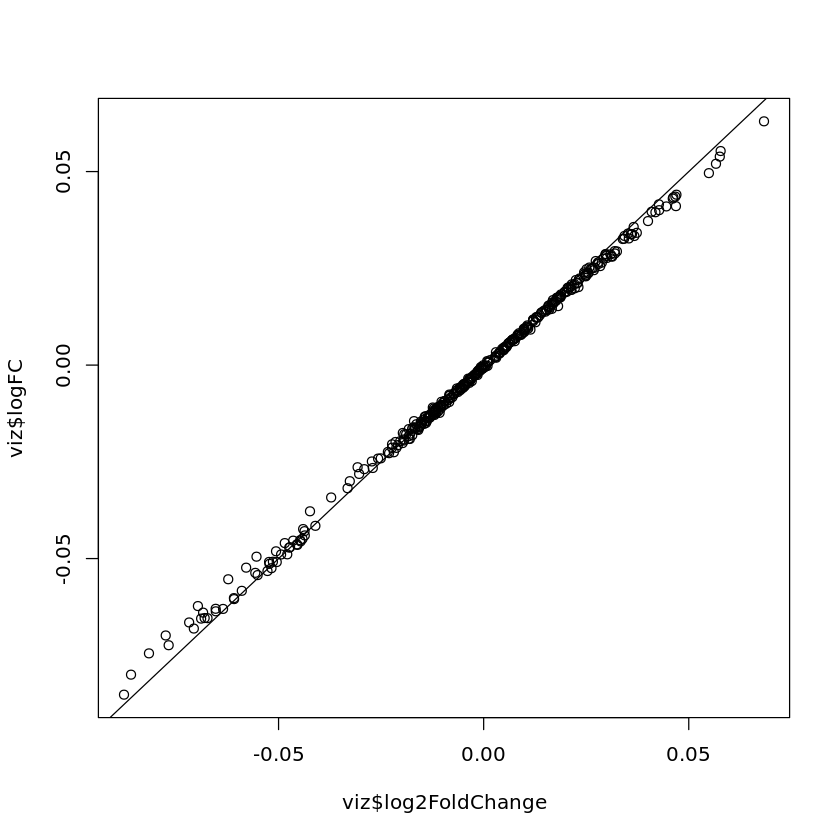

In [18]:
dds3 <- DESeq(dds3)
res <- results(dds3, name='gen')
summary(res)

# compare with limma
limma_umi_results_file = './limma/ladder_pilot_limma_umi_res.txt'
limma_umi_results = read.table(file = limma_umi_results_file, header = TRUE, sep = '\t', row.names = 1)

# log2FoldChange vs logFC
viz <- cbind(res, limma_umi_results[rownames(res),])
plot(viz$log2FoldChange,viz$logFC)
abline(a=0, b=1)

## Break down DESeq function steps to select specific control genes

In [19]:
# get neutral PBCs
neutral_pbc

[1] "ACTAATGCCCGC" "CTAACAAGGCAC"

In [20]:
# re-run DESeq
dds3 <- DESeqDataSetFromMatrix(countData = as.matrix(counts, rownames = 1),
                              colData = samples,
                              design= ~gen+rep)

# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 1000

keep <- rowSums(counts(dds3)) >= total_reads_cutoff
dds3 <- dds3[keep,]

# estimate size factors, specifying neutral oligos as control genes
dds3 <- estimateSizeFactors(dds3, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds3)))
# estimate dispersion
dds3 <- estimateDispersions(dds3)
# calculate logFC
dds3 <- nbinomWaldTest(dds3)


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



## Compare DESeq log2FoldChange to limma logFC_adj (adjusted by mean logFC of neutral PBCs)


out of 375 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 103, 27%
LFC < 0 (down)     : 220, 59%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



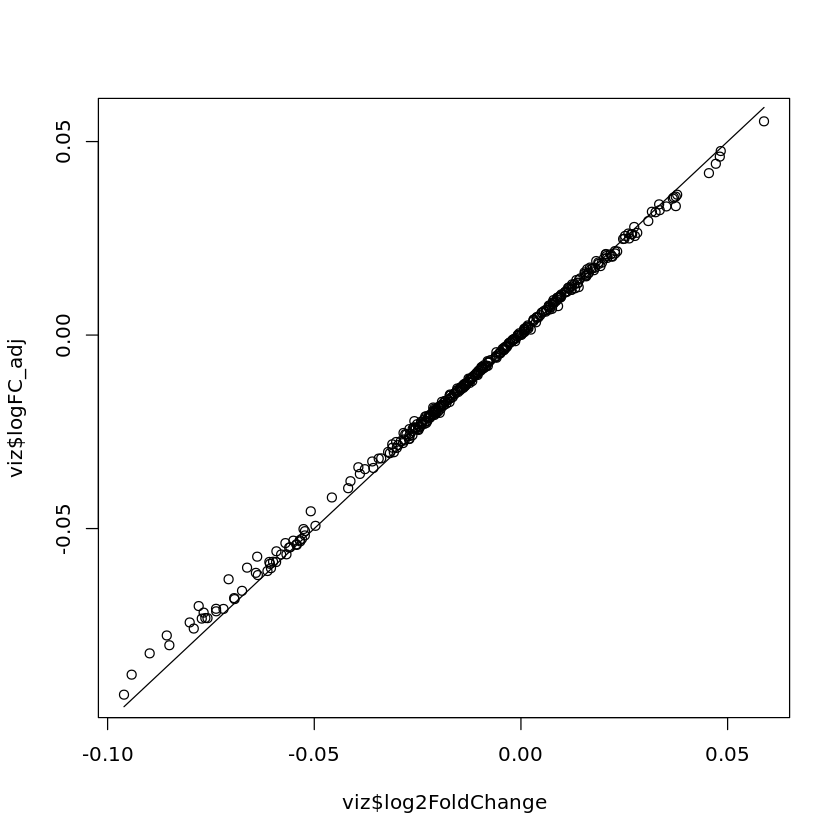

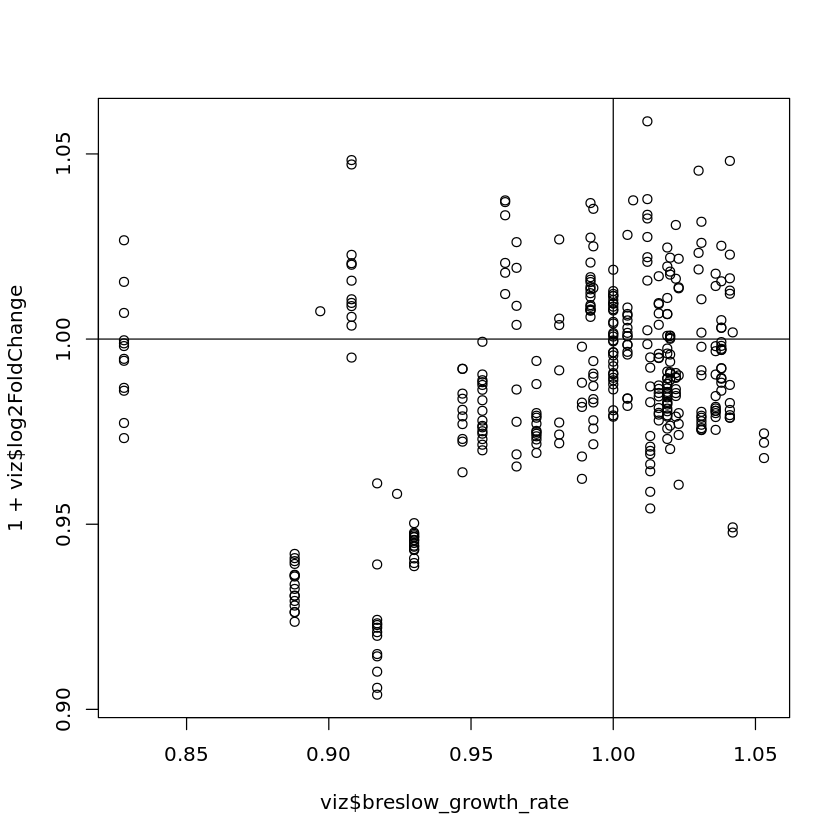

In [21]:
res <- results(dds3, name='gen')
summary(res)

# compare with limma (annotated)
limma_results_annotated_file <- 'ladder_pilot_limma_umi_res_annotated.txt'
limma_results_annotated <- read.table(file = limma_results_annotated_file, header = TRUE, sep = '\t', row.names = 1)
rownames(limma_results_annotated) = limma_results_annotated$barcode

# log2FoldChange vs logFC_adj
viz <- cbind(res, limma_results_annotated[rownames(res),])
plot(viz$log2FoldChange,viz$logFC_adj)
lines(viz$log2FoldChange, viz$log2FoldChange, type = "l")

# breslow_growth_rate vs log2FoldChange->fitness
plot(viz$breslow_growth_rate, 1+viz$log2FoldChange)
abline(h=1)
abline(v=1)

# # log2FoldChange->fitness vs crispey_fitness
# plot(2**viz$log2FoldChange,viz$crispey_fitness)
# lines(2**viz$log2FoldChange, 2**viz$log2FoldChange, type = "l")

# # breslow_growth_rate vs crispey_fitness
# plot(viz$breslow_growth_rate, viz$crispey_fitness)
# abline(h=1)
# abline(v=1)

In [22]:
# view table of results sorted by pvalue
resOrdered <- res[order(res$pvalue),]
resOrdered

# export results to file
write.csv(as.data.frame(resOrdered), file=deseq_output_file)

log2 fold change (MLE): gen 
Wald test p-value: gen 
DataFrame with 375 rows and 6 columns
                               baseMean        log2FoldChange
                              <numeric>             <numeric>
TTGATCATTCCG_CTGTGTATC 132.329797128302   -0.0692697310876828
TTGATCATTCCG_CTGTGGCAA 94.1405948354354   -0.0693886808682907
TTGATCATTCCG_ATGTGCGAA 69.7587839236088   -0.0763514063957872
TTGATCATTCCG_TAGAGGACT 72.5075318526651   -0.0719680375128362
ACTTGCGTAACG_TAGAGGACT  119.34979065554   -0.0604840296326462
...                                 ...                   ...
CTAACAAGGCAC_AAGAGGAGG 77.5908711851806 -0.000612984953962452
ACTAATGCCCGC_ATGTGTAGG 112.072740228771 -0.000364860242078877
GTAATTGGGCTG_GTGTGATTC  85.545483489023   0.00034060587456819
CACTGCTGAGCC_CAGAGCCAA 76.1087865847804 -0.000325807013999338
GTAATTGGGCTG_TTGTGCGTC 70.9850163320809  7.40223327139205e-05
                                     lfcSE               stat
                                 <numeric

### We can prototype a GxG/GxE analysis workflow in DESeq2 by modifying the sample info table to create two pseudo conditions between rep123 and rep456 (called "cond"), and fitting a new design with gen*cond and rep*cond interaction terms...

In [23]:
samples_pseudocond_file <- "./ladder_pilot_samples_pseudoConditions.txt"
# loading samples
samples_pseudocond <- read.table(file = samples_pseudocond_file, header = TRUE, sep = '\t', row.names = 1)
samples_pseudocond$rep = factor(samples_pseudocond$rep)

In [24]:
# re-run DESeq
dds4 <- DESeqDataSetFromMatrix(countData = as.matrix(counts, rownames = 1),
                                         colData = samples_pseudocond,
                                         design= ~gen+rep+cond+gen:cond+rep:cond)

# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 1000

keep <- rowSums(counts(dds4)) >= total_reads_cutoff
dds4 <- dds4[keep,]

# estimate size factors, specifying neutral oligos as control genes
dds4 <- estimateSizeFactors(dds4, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds4)))
# estimate dispersion
dds4 <- estimateDispersions(dds4)
# calculate logFC
dds4 <- nbinomWaldTest(dds4)


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [25]:
resultsNames(dds4)

[1] "Intercept"   "gen"         "rep_2_vs_1"  "rep_3_vs_1"  "cond_B_vs_A"
[6] "gen.condB"   "rep2.condB"  "rep3.condB"

In [26]:
# fitness in cond A (rep123)
res2 <- results(dds4, name='gen')
summary(res2)

# fitness in cond B (rep456)
res3 <- results(dds4, contrast=list( c("gen","gen.condB") ))
summary(res3)

# identify significant changes in fitness between conditions
res4 <- results(dds4, name='gen.condB')
summary(res4)

# when comparing across multiple conds (e.g. GxG comparing between non-reference strains), use list to compare interaction terms directly
# e.g. results(dds4, contrast=list("gen.condC", "gen.condB")) 


out of 375 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 91, 24%
LFC < 0 (down)     : 195, 52%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 375 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 90, 24%
LFC < 0 (down)     : 208, 55%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 375 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 0.9680533

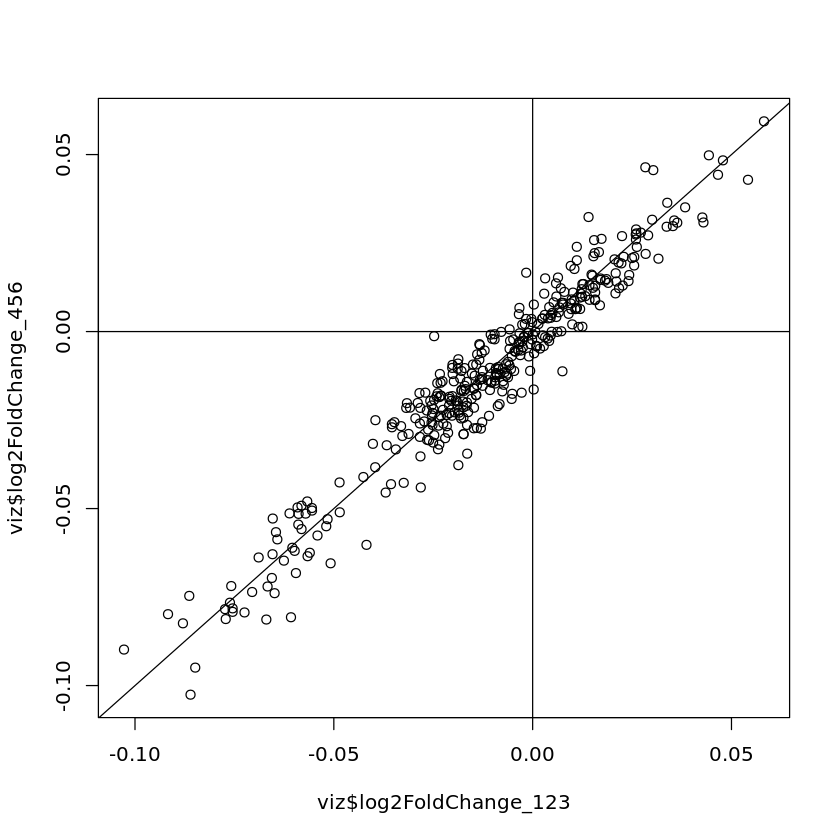

In [27]:
# log2FoldChange (rep123) vs log2FoldChange (rep456)
viz <- cbind(res2, res3[rownames(res2),])
colnames(viz) <- c(paste0(colnames(res2), "_123"), paste0(colnames(res3), "_456"))
plot(viz$log2FoldChange_123,viz$log2FoldChange_456)
abline(a=0,b=1)
abline(h=0)
abline(v=0)
cor(viz$log2FoldChange_123,viz$log2FoldChange_456)

# Compare PBC results and UMI results

In [87]:
res_pbc = results(dds, name='gen')
res_pbc$PBC = rownames(res_pbc)
res_pbc$logP_sign = -log10(res_pbc$padj)*sign(res_pbc$log2FoldChange)

res_umi = results(dds3, name='gen')
res_umi$PBC = sapply(strsplit(rownames(res_umi), '_'), `[`, 1)
res_umi$UMI = sapply(strsplit(rownames(res_umi), '_'), `[`, 2)
res_umi$logP_sign = -log10(res_umi$padj)*sign(res_umi$log2FoldChange)

df = merge(x=as.data.frame(res_umi), y=as.data.frame(res_pbc), by='PBC', all.x=TRUE, suffixes = c("_umi","_pbc"))


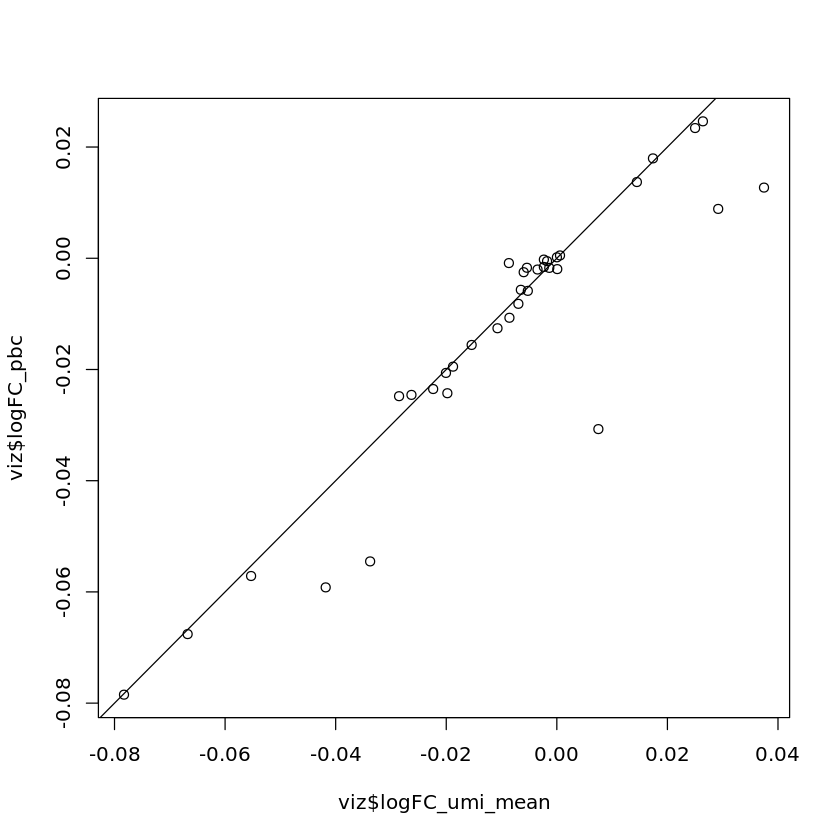

In [88]:
viz <- df %>% 
        group_by(PBC) %>%
        summarize(logFC_umi_mean=mean(log2FoldChange_umi), logFC_pbc=mean(log2FoldChange_pbc))

plot(viz$logFC_umi_mean, viz$logFC_pbc)
abline(0,1)

PBC,n_umi,n_umi_agree,pbc_logP_sign,umi_agree_frac
<chr>,<int>,<int>,<dbl>,<dbl>
ACGACTAAGTTG,13,13,-Inf,1.0000000
TTGATCATTCCG,16,16,-Inf,1.0000000
GTGAACGTAGGT,3,2,-245.23020814,0.6666667
ACTTGCGTAACG,16,16,-223.65763457,1.0000000
TACTTCGCACTC,1,1,-178.83696834,1.0000000
GGTATTAAGGGA,16,15,-95.57369327,0.9375000
AGGAAATAGACT,12,10,-94.76156926,0.8333333
GGTCTCTGTCGG,6,5,-48.89546975,0.8333333
GTCTCCAAGCGC,10,8,-47.05455322,0.8000000


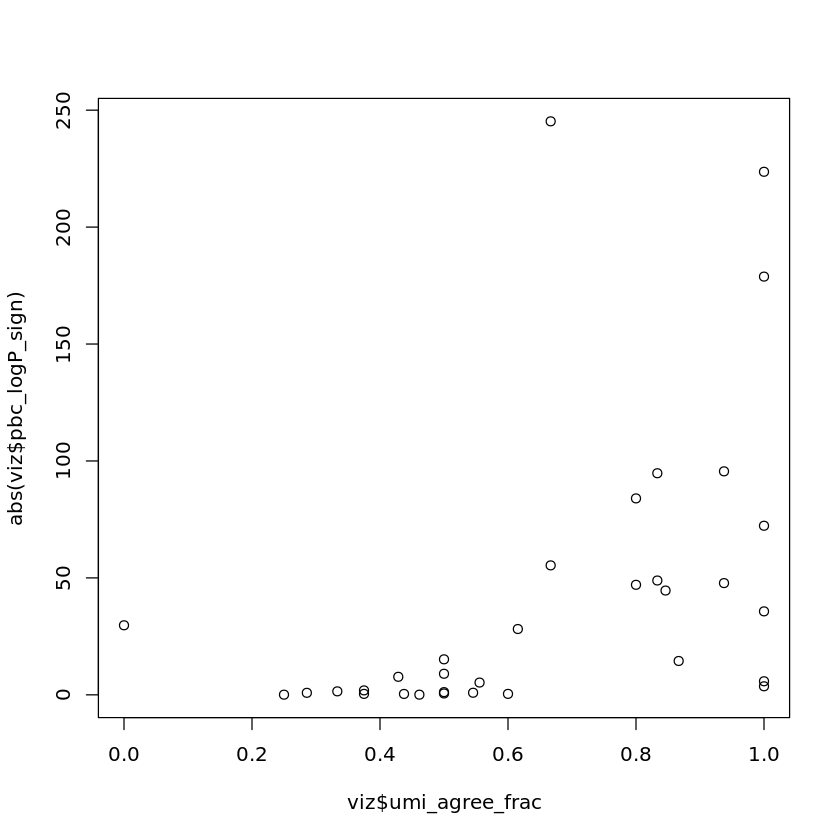

In [109]:
df$agreement = abs(df$logP_sign_umi)>2 & (sign(df$logP_sign_umi)==sign(df$logP_sign_pbc))
viz <- df %>% 
       group_by(PBC) %>%
       summarize(n_umi=n(), n_umi_agree=sum(agreement), pbc_logP_sign=mean(logP_sign_pbc))

viz$umi_agree_frac = viz$n_umi_agree/viz$n_umi
viz[order(viz$pbc_logP_sign),]

plot(viz$umi_agree_frac, abs(viz$pbc_logP_sign), )

In [116]:
subset(df, df$PBC=="ACTAATGCCCGC")

,PBC,baseMean_umi,log2FoldChange_umi,lfcSE_umi,stat_umi,pvalue_umi,padj_umi,UMI,logP_sign_umi,baseMean_pbc,log2FoldChange_pbc,lfcSE_pbc,stat_pbc,pvalue_pbc,padj_pbc,logP_sign_pbc,agreement
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
21,ACTAATGCCCGC,115.30547,-0.0136024034,0.002616059,-5.1995783,1.997412e-07,4.161275e-07,AAGAGCCTC,-6.38077358,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,TRUE
22,ACTAATGCCCGC,53.18865,-0.0122275487,0.003647070,-3.3527049,8.002598e-04,1.136733e-03,AAGAGGAGG,-2.94434168,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,TRUE
23,ACTAATGCCCGC,73.03359,0.0006795967,0.003159476,0.2150980,8.296910e-01,8.409030e-01,ACGCGTGAA,0.07525410,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,FALSE
24,ACTAATGCCCGC,125.74019,-0.0104503162,0.002404965,-4.3453092,1.390796e-05,2.328342e-05,ATGTGCGAA,-4.63295325,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,TRUE
25,ACTAATGCCCGC,259.18765,0.0042048386,0.001756127,2.3943824,1.664838e-02,2.109170e-02,ATGTGGCTC,1.67588848,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,FALSE
26,ACTAATGCCCGC,112.07274,-0.0003648602,0.002519613,-0.1448081,8.848624e-01,8.919984e-01,ATGTGTAGG,-0.04963593,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,FALSE
27,ACTAATGCCCGC,119.75737,0.0016107297,0.002452052,0.6568906,5.112512e-01,5.431139e-01,CAGAGCCAA,0.26510907,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,FALSE
28,ACTAATGCCCGC,202.90358,-0.0035615382,0.002038091,-1.7474871,8.055288e-02,9.410383e-02,CAGAGGATC,-1.02639270,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,FALSE
29,ACTAATGCCCGC,232.95875,0.0046382560,0.001872973,2.4764139,1.327096e-02,1.686987e-02,CTGTGATGG,1.77288831,2563.277,-0.000524257,0.0005632376,-0.9307918,0.3519613,0.3790352,-0.4213204,FALSE


# Going back to PBC-level analysis, how well do logFC from two sets of triplicates agree with each other in separate analyses? (rep135 vs rep246)

In [37]:
# samples info file
samples_info_file = "./ladder_pilot_samples.txt"
# counts file
counts_file = "./counts/pbc_counts.txt"

# output directory
dir.create("./deseq/")
# deseq results file
deseq_rep135_output_file= "./deseq/ladder_pilot_deseq_rep135_results.txt"
deseq_rep246_output_file= "./deseq/ladder_pilot_deseq_rep246_results.txt"

print("Input files:")
print(samples_info_file)
print(counts_file)
print("Output files:")
print(deseq_rep135_output_file)
print(deseq_rep246_output_file)

Warning message in dir.create("./deseq/"):
“'./deseq' already exists”


[1] "Input files:"
[1] "./ladder_pilot_samples.txt"
[1] "./counts/pbc_counts.txt"
[1] "Output files:"
[1] "./deseq/ladder_pilot_deseq_rep135_results.txt"
[1] "./deseq/ladder_pilot_deseq_rep246_results.txt"


## Select specific control genes

In [38]:
ladder_oligos_annotation_file <- 'ladder_oligos_annotated.txt'
ladder_oligos_annotation <- fread(file = ladder_oligos_annotation_file, header = TRUE, sep = '\t', data.table=FALSE)

# get neutral PBCs
neutral_pbc = as.vector(ladder_oligos_annotation[ladder_oligos_annotation$breslow_growth_rate==1,'PBC'])
neutral_pbc

[1] "ACTAATGCCCGC" "CTAACAAGGCAC"

## Load samples info, barcode counts

In [39]:
# loading samples
samples <- read.table(file = samples_info_file, header = TRUE, sep = '\t', row.names = 1)

# loading counts
counts <- read.table(file = counts_file, header = TRUE, sep = '\t', row.names = 1)
colnames(counts) <- rownames(samples)

# separate samples and counts files
samples135 <- samples[seq(1,41,by=2),]
samples135$rep = factor(samples135$rep)
samples246 <- samples[seq(2,42,by=2),]
samples246$rep = factor(samples246$rep)

counts135 <- counts[,rownames(samples135)]
counts246 <- counts[,rownames(samples246)]


# # DDS overview
# dds135
# dds246

In [41]:
# store in DESeqDataSet
dds135 <- DESeqDataSetFromMatrix(countData = counts135,
                                 colData = samples135,
                                 design= ~gen+rep)
dds246 <- DESeqDataSetFromMatrix(countData = counts246,
                                 colData = samples246,
                                 design= ~gen+rep)


# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 500

keep <- rowSums(counts(dds135)) >= total_reads_cutoff
dds135 <- dds135[keep,]
keep <- rowSums(counts(dds246)) >= total_reads_cutoff
dds246 <- dds246[keep,]


# estimate size factors, specifying neutral oligos as control genes
dds135 <- estimateSizeFactors(dds135, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds135)))
# estimate dispersion
dds135 <- estimateDispersions(dds135)
# calculate logFC
dds135 <- nbinomWaldTest(dds135)

# estimate size factors, specifying neutral oligos as control genes
dds246 <- estimateSizeFactors(dds246, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds246)))
# estimate dispersion
dds246 <- estimateDispersions(dds246)
# calculate logFC
dds246 <- nbinomWaldTest(dds246)


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [42]:
# rep135 logFC results
res135 <- results(dds135, name='gen', alpha=0.05)
summary(res135)

# view table of results sorted by pvalue
res135Ordered <- res135[order(res135$pvalue),]
res135Ordered

# export results to file
write.csv(as.data.frame(res135Ordered), file=deseq_rep135_output_file)



# rep246 logFC results
res246 <- results(dds246, name='gen', alpha=0.05)
summary(res246)

# view table of results sorted by pvalue
res246Ordered <- res246[order(res246$pvalue),]
res246Ordered

# export results to file
write.csv(as.data.frame(res246Ordered), file=deseq_rep246_output_file)


out of 42 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6, 14%
LFC < 0 (down)     : 25, 60%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): gen 
Wald test p-value: gen 
DataFrame with 42 rows and 6 columns
                     baseMean        log2FoldChange                lfcSE
                    <numeric>             <numeric>            <numeric>
ACGACTAAGTTG 548.513221877657   -0.0783227182511869  0.00190245804045143
TTGATCATTCCG 1103.97337717381   -0.0676488627141563  0.00158510736325187
AGTCGCATTGAG 109.435656882396      -0.1253540926697  0.00441386726684553
GTGAACGTAGGT 292.373237213876   -0.0563036636539121  0.00233600770382501
ACTTGCGTAACG 1430.23863474323   -0.0568425302764375  0.00256207413080682
...                       ...                   ...                  ...
ACTAATGCCCGC 2596.21957894445 -0.000433161402804888 0.000880990718546461
CTAACAAGGCAC 2273.01824948567  0.000404747862382369 0.000913274246810777
TCGTCTGGTTCC 52.2883810944513  -0.00187924261091869  0.00524526727761108
GAGCAACCAGTA 2433.07767817205 -0.000347788881279237  0.00121276847581478
CGCAGTCGTCAA 754.273824383176  -0.


out of 42 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5, 12%
LFC < 0 (down)     : 24, 57%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 25)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): gen 
Wald test p-value: gen 
DataFrame with 42 rows and 6 columns
                     baseMean        log2FoldChange                lfcSE
                    <numeric>             <numeric>            <numeric>
TTGATCATTCCG  1076.2220295672   -0.0676076475307783  0.00188291966701849
ACGACTAAGTTG 531.543249808024   -0.0787383466102426   0.0022022288449472
AGTCGCATTGAG 107.603154764754    -0.115421132728705  0.00453851677526557
ACTTGCGTAACG 1393.41493240214   -0.0574280214454949  0.00244869297123883
GTGAACGTAGGT 281.913777992218   -0.0526426988291508  0.00237351661989772
...                       ...                   ...                  ...
CTAACAAGGCAC   2232.893518508  0.000618329135230688 0.000851820264596602
CAACCGTGGGCT  1239.0885409663 -0.000869537121716643  0.00130889819729172
GAGCAACCAGTA 2397.77167140582  0.000695873152523208  0.00110106876251934
GTACTGTACCTC 416.251673666386  -0.00093286206190362   0.0019118066071869
CGCAGTCGTCAA 758.116328043978 -8.2

# We can also calculate logFC from start-end time point analyses (tp05, tp16)

In [58]:
# samples info file
samples_info_file = "./ladder_pilot_samples.txt"
# counts file
counts_file = "./counts/pbc_counts.txt"

# output directory
dir.create("./deseq/")
# deseq results file
deseq_tp05_output_file= "./deseq/ladder_pilot_deseq_tp05_results.txt"
deseq_tp16_output_file= "./deseq/ladder_pilot_deseq_tp16_results.txt"

print("Input files:")
print(samples_info_file)
print(counts_file)
print("Output files:")
print(deseq_tp05_output_file)
print(deseq_tp16_output_file)

Warning message in dir.create("./deseq/"):
“'./deseq' already exists”


[1] "Input files:"
[1] "./ladder_pilot_samples.txt"
[1] "./counts/pbc_counts.txt"
[1] "Output files:"
[1] "./deseq/ladder_pilot_deseq_tp05_results.txt"
[1] "./deseq/ladder_pilot_deseq_tp16_results.txt"


## Select specific control genes

In [59]:
ladder_oligos_annotation_file <- 'ladder_oligos_annotated.txt'
ladder_oligos_annotation <- fread(file = ladder_oligos_annotation_file, header = TRUE, sep = '\t', data.table=FALSE)

# get neutral PBCs
neutral_pbc = as.vector(ladder_oligos_annotation[ladder_oligos_annotation$breslow_growth_rate==1,'PBC'])
neutral_pbc

[1] "ACTAATGCCCGC" "CTAACAAGGCAC"

## Load samples info, barcode counts

In [60]:
# loading samples
samples <- read.table(file = samples_info_file, header = TRUE, sep = '\t', row.names = 1)

# loading counts
counts <- read.table(file = counts_file, header = TRUE, sep = '\t', row.names = 1)
colnames(counts) <- rownames(samples)

# separate samples and counts files
samples_tp05 <- samples[c(1:6,31:36),]
samples_tp05$rep = factor(samples_tp05$rep)
samples_tp16 <- samples[c(7:12,37:42),]
samples_tp16$rep = factor(samples_tp16$rep)

counts_tp05 <- counts[,rownames(samples_tp05)]
counts_tp16 <- counts[,rownames(samples_tp16)]


# # DDS overview
# dds_tp05
# dds_tp16

In [61]:
# store in DESeqDataSet
dds_tp05 <- DESeqDataSetFromMatrix(countData = counts_tp05,
                                 colData = samples_tp05,
                                 design= ~gen+rep)
dds_tp16 <- DESeqDataSetFromMatrix(countData = counts_tp16,
                                 colData = samples_tp16,
                                 design= ~gen+rep)


# filter barcodes that do not meet minimum read cutoff
total_reads_cutoff = 250

keep <- rowSums(counts(dds_tp05)) >= total_reads_cutoff
dds_tp05 <- dds_tp05[keep,]
keep <- rowSums(counts(dds_tp16)) >= total_reads_cutoff
dds_tp16 <- dds_tp16[keep,]


# estimate size factors, specifying neutral oligos as control genes
dds_tp05 <- estimateSizeFactors(dds_tp05, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds_tp05)))
# estimate dispersion
dds_tp05 <- estimateDispersions(dds_tp05)
# calculate logFC
dds_tp05 <- nbinomWaldTest(dds_tp05)

# estimate size factors, specifying neutral oligos as control genes
dds_tp16 <- estimateSizeFactors(dds_tp16, controlGenes=grep(paste(neutral_pbc, collapse="|"), rownames(dds_tp16)))
# estimate dispersion
dds_tp16 <- estimateDispersions(dds_tp16)
# calculate logFC
dds_tp16 <- nbinomWaldTest(dds_tp16)


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [62]:
# rep_tp05 logFC results
res_tp05 <- results(dds_tp05, name='gen', alpha=0.05)
summary(res_tp05)

# view table of results sorted by pvalue
res_tp05Ordered <- res_tp05[order(res_tp05$pvalue),]
res_tp05Ordered

# export results to file
write.csv(as.data.frame(res_tp05Ordered), file=deseq_tp05_output_file)



# rep_tp16 logFC results
res_tp16 <- results(dds_tp16, name='gen', alpha=0.05)
summary(res_tp16)

# view table of results sorted by pvalue
res_tp16Ordered <- res_tp16[order(res_tp16$pvalue),]
res_tp16Ordered

# export results to file
write.csv(as.data.frame(res_tp16Ordered), file=deseq_tp16_output_file)


out of 42 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4, 9.5%
LFC < 0 (down)     : 25, 60%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 29)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): gen 
Wald test p-value: gen 
DataFrame with 42 rows and 6 columns
                     baseMean        log2FoldChange               lfcSE
                    <numeric>             <numeric>           <numeric>
TTGATCATTCCG 1257.68211548541    -0.065967518659352 0.00186577817258197
ACGACTAAGTTG 642.321704437577   -0.0782799107122274 0.00226321839330136
ACTTGCGTAACG 1503.45688832851   -0.0538473036064852 0.00198184778315778
AGTCGCATTGAG 146.982232468154    -0.123207429649612 0.00548619624190563
GTGAACGTAGGT 325.702231418638   -0.0588874248772959 0.00280737528223826
...                       ...                   ...                 ...
GTAATTGGGCTG 944.305346671925  -0.00166578202150348 0.00167407676373844
GAGCAACCAGTA  2445.3035481194   -0.0007093978943348 0.00132809951925265
ACTAATGCCCGC 2605.48719523982   -0.0004565467874937 0.00121033097596882
CTAACAAGGCAC 2265.96068446493  0.000449818722231959 0.00125417702849333
CAACCGTGGGCT 1254.35329617785 -0.0003694896231


out of 42 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5, 12%
LFC < 0 (down)     : 21, 50%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): gen 
Wald test p-value: gen 
DataFrame with 42 rows and 6 columns
                     baseMean        log2FoldChange               lfcSE
                    <numeric>             <numeric>           <numeric>
TTGATCATTCCG 1035.73383385575   -0.0708499867185864 0.00218935150945651
ACGACTAAGTTG 511.930134362507   -0.0805505183620703  0.0028058480940214
ACTTGCGTAACG 1322.20269498939   -0.0612106041036994  0.0021827242569575
AGTCGCATTGAG 105.483848377699    -0.115278239806096 0.00684652438212138
GTGAACGTAGGT 278.661327422388   -0.0512230784451799 0.00351490342572949
...                       ...                   ...                 ...
TGAAGTCCTTTA 3639.31695737347 -0.000727606003174637 0.00139318480988604
GTACTGTACCTC 425.718150482907  0.000507710651127869 0.00296223643577781
ACTAATGCCCGC 2536.78745862493 -0.000109708111839465 0.00144048358108156
CTAACAAGGCAC 2267.30850523727   0.00010814048248271 0.00148655577715394
TTGAGAATAGCA 509.925922040672 -0.0001785856166

## What if we use only three time points? (t1,3,5 vs t2,4,6)

In [47]:
# setup linear model factoring in num of generations, replicate
samples_tp135 <- samples[c(7:12,19:24,31:36),]
samples_tp135$rep = factor(samples_tp135$rep)
samples_tp246 <- samples[c(13:18,25:30,37:42),]
samples_tp135$rep = factor(samples_tp135$rep)
samples_tp246$rep = factor(samples_tp246$rep)

design_tp135 <- model.matrix(~gen+rep, samples_tp135)
design_tp246 <- model.matrix(~gen+rep, samples_tp246)

dge_tp135 <- dge[,c(7:12,19:24,31:36), keep.lib.size = FALSE]
dge_tp246 <- dge[,c(13:18,25:30,37:42), keep.lib.size = FALSE]

# apply normalization
dge_tp135 <- calcNormFactors(dge_tp135)
dge_tp246 <- calcNormFactors(dge_tp246)

In [48]:
# limma-trend -- tp135
logCPM <- cpm(dge_tp135, log=TRUE, prior.count=3)
fit <- lmFit(logCPM, design_tp135)
fit <- eBayes(fit, trend=TRUE)

# this shows what number of effect are differnt from zero for each variable 
print(summary(decideTests(fit)))
# show results
results = topTable(fit,coef=2, number = 1000, confint=TRUE)
head(results)

write.table(results, 
            file= sub(".txt", "_tp135.txt", limma_output_file), 
            sep="\t", quote = FALSE,na = "", row.names = TRUE, col.names = TRUE)



# limma-trend -- tp246
logCPM <- cpm(dge_tp246, log=TRUE, prior.count=3)
fit <- lmFit(logCPM, design_tp246)
fit <- eBayes(fit, trend=TRUE)

# this shows what number of effect are differnt from zero for each variable 
print(summary(decideTests(fit)))
# show results
results = topTable(fit,coef=2, number = 1000, confint=TRUE)
head(results)

write.table(results, 
            file= sub(".txt", "_tp246.txt", limma_output_file), 
            sep="\t", quote = FALSE,na = "", row.names = TRUE, col.names = TRUE)

       (Intercept) gen rep2 rep3 rep4 rep5 rep6
Down             0  17    0    0    0    0    1
NotSig           0   7   42   42   42   42   41
Up              42  18    0    0    0    0    0


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TTGATCATTCCG,-0.05855083,-0.06168186,-0.05541980,14.78360,-36.74795,3.220499e-139,1.352609e-137,666.3858
ACTTGCGTAACG,-0.04979411,-0.05271880,-0.04686942,15.17380,-33.45690,1.584710e-125,3.327891e-124,550.9011
ACGACTAAGTTG,-0.07016929,-0.07451912,-0.06581947,13.70674,-31.70022,5.553795e-118,7.775314e-117,493.6903
AGTCGCATTGAG,-0.11348543,-0.12296060,-0.10401026,11.17952,-23.53642,4.403615e-81,4.623796e-80,268.2958
CCATCCGCGGGT,0.03628630,0.03242160,0.04015101,14.03756,18.45073,2.336703e-57,1.962831e-56,161.5652
CCAGGCAGCGAC,0.02447928,0.02179577,0.02716279,16.18265,17.92597,6.183818e-55,4.328673e-54,152.0238


       (Intercept) gen rep2 rep3 rep4 rep5 rep6
Down             0  18    0    0    0    0    0
NotSig           0   6   42   42   42   42   42
Up              42  18    0    0    0    0    0


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TTGATCATTCCG,-0.05940322,-0.06315730,-0.05564914,14.45130,-31.95337,1.150286e-30,4.831202e-29,59.81155
ACTTGCGTAACG,-0.05825105,-0.06221911,-0.05428299,14.95854,-29.64393,2.220315e-29,4.662661e-28,56.81510
ACGACTAAGTTG,-0.07126394,-0.07651455,-0.06601334,13.36329,-27.40757,4.803858e-28,6.725401e-27,53.69907
TACTTCGCACTC,-0.05943975,-0.06665487,-0.05222463,12.30286,-16.63580,7.183031e-20,6.714627e-19,34.56951
CCATCCGCGGGT,0.03355705,0.02947157,0.03764253,14.17652,16.58635,7.993603e-20,6.714627e-19,34.46074
TTGCCATTGTCC,0.03443383,0.02995674,0.03891091,13.84756,15.53103,8.299670e-19,5.809769e-18,32.08033
